In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Rotated and scaled')

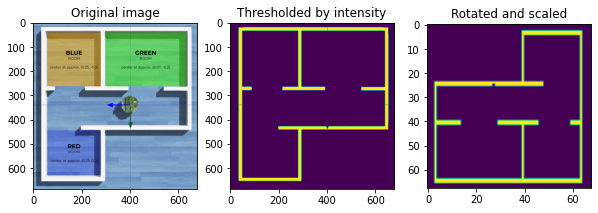

In [31]:
%matplotlib inline

fix, ax = plt.subplots(1, 3, figsize=(10, 5))

im = cv2.imread('data/map_webots.png')
ax[0].imshow(im)
ax[0].set_title('Original image')

gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
gray = (gray >= 246).astype(np.uint8)
ax[1].imshow(gray)
ax[1].set_title('Thresholded by intensity')

resize_factor = 9.95
map_ground = cv2.rotate(gray, cv2.ROTATE_180)
map_ground = cv2.resize(map_ground, (int(map_ground.shape[0] / resize_factor), int(map_ground.shape[1] / resize_factor)))
map_ground[map_ground < 0.5] = 0
map_ground[map_ground >= 0.5] = 1
map_ground = map_ground.astype(np.float32)
ax[2].imshow(map_ground)
ax[2].set_title('Rotated and scaled')

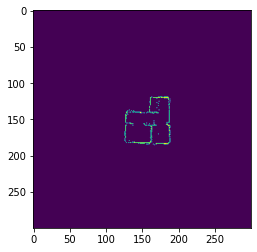

In [23]:
%matplotlib inline


def get_constructed_map(filename):
    map_phy = cv2.cvtColor(cv2.imread(f'data/{filename}.pgm'), cv2.COLOR_BGR2GRAY)
    map_phy = (map_phy < 0.5)
    map_phy[map_phy < 0.5] = 0
    map_phy[map_phy >= 0.5] = 1
    return map_phy.astype(np.float32)


map_phy = get_constructed_map('map_phy_2')
plt.imshow(map_phy)

In [28]:
def find_min_diff_image(image, sub_image):
    w, h = sub_image.shape
    max_iou = None
    min_x, min_y = 0, 0
    for i in range(0, image.shape[0] - w):
        for j in range(0, image.shape[1] - h):
            map_diff = image.copy()
            intersection = cv2.bitwise_and(map_diff[i:i+w, j:j+h], sub_image)
            union = cv2.bitwise_or(map_diff[i:i+w, j:j+h], sub_image)
            iou = np.sum(intersection) / np.sum(union)
            if max_iou is None or iou > max_iou:
                max_iou = iou
                min_x = i
                min_y = j
                
    return max_iou, min_x, min_y
                
for i in range(1, 4, 1):
    map_phy = get_constructed_map(f'map_phy_{i}')
    iou, x, y = find_min_diff_image(map_phy, map_ground)
    print(iou, x, y)
    
    
map_phy = get_constructed_map(f'map_sim_1')
iou, x, y = find_min_diff_image(map_phy, map_ground)
print(iou, x, y)

0.2792208 116 124
0.2596006 117 124
0.29588607 117 124
0.4093098 116 122
